1.1 Problem Statement
You are a cab rental start-up company. You have successfully run the pilot project and now want to launch your cab service across the country. You have collected the historical data from your pilot project and now have a requirement to apply analytics for fare prediction. You need to design a system that predicts the fare amount for a cab ride in the city. 


1.2 Data Preprocessing
Our task is to build a models which will predict the Cab fare based on the date-time and other given features. Given below is a sample of the data set that we are using to predict the Cab fare:

Number of attributes: pickup_datetime - timestamp value indicating when the cab ride started. 
pickup_longitude - float for longitude coordinate of where the cab ride started.     
pickup_latitude - float for latitude coordinate of where the cab ride started.          
dropoff_longitude - float for longitude coordinate of where the cab ride ended.          
dropoff_latitude - float for latitude coordinate of where the cab ride ended.          
passenger_count - an integer indicating the number of passengers in the cab ride. 
 
 

In [1]:
#Import libraries to visualize and clean data
import pandas as pd
import numpy as np
pd.set_option('max_columns', 105)

import seaborn as sns
#Set color palette for graphs
sns.set_palette(sns.color_palette('hls', 7))

import matplotlib.pyplot as plt
from scipy import stats

import scipy.stats
from scipy.stats import norm, skew #for some statistics
import time
from sklearn.preprocessing import LabelEncoder, RobustScaler

#Silencing deprication warnings
import warnings
warnings.filterwarnings("ignore")

#Import libraries for modeling and validation
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, make_pipeline

#Import libraries for stacking 
from mlens.metrics.metrics import rmse
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'

[MLENS] backend: threading


In [2]:
train =  pd.read_csv('train_cab.csv', nrows = 10_000_000)
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [3]:
print (train.shape)
train.info()

(16067, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


# Changing Datatype 

In [4]:
train['fare_amount'] = pd.to_numeric(train['fare_amount'], errors='coerce')
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], errors='coerce')

In [5]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.7 KB


In [7]:
#to view all null values
train.isnull().sum().sort_values(ascending=False)

passenger_count      55
fare_amount          25
pickup_datetime       1
dropoff_latitude      0
dropoff_longitude     0
pickup_latitude       0
pickup_longitude      0
dtype: int64

In [8]:
#for dropping all null values
drop_train=train.drop(train[train.isnull().any(1)].index,axis=0)
print(drop_train.shape)

(15986, 7)


In [9]:
import pandas_profiling

# select passenger count

In [10]:
drop_train = drop_train[(drop_train.passenger_count>=1) & (drop_train.passenger_count<=6)]

In [11]:
drop_train = drop_train.drop(drop_train[drop_train.passenger_count == 1.3].index, axis=0)

In [12]:
drop_train.passenger_count.value_counts()

1.0    11241
2.0     2319
5.0     1044
3.0      675
4.0      328
6.0      301
Name: passenger_count, dtype: int64

In [13]:
#dropping observations from fare Amount with negatives values and 0 values
#drop_train = drop_train.drop(drop_train[drop_train.fare_amount == 0 ].index)
drop_train = drop_train.drop(drop_train[drop_train.fare_amount <= 0].index)

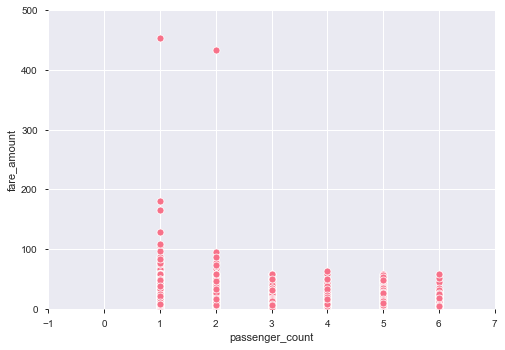

In [14]:
ax = sns.scatterplot(x="passenger_count", y="fare_amount", data=drop_train)
ax.set(xlim=(-1, 7))
ax.set(ylim=(-1,500))
plt.show()

# deleting values greater than 100 or negative


In [15]:
#deleting values greater than 100 or negative
index_fc = drop_train.loc[drop_train.fare_amount > 100,:].index
drop_train.drop(index_fc, axis = 0, inplace = True)

index_fc1 = drop_train.loc[drop_train.fare_amount < 0, :].index
drop_train.drop(index_fc1, axis = 0, inplace = True)

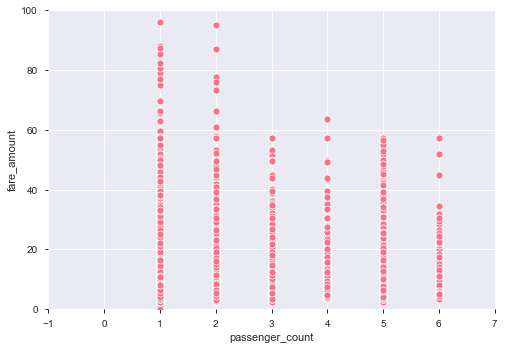

In [16]:
ax = sns.scatterplot(x="passenger_count", y="fare_amount", data=drop_train)
ax.set(xlim=(-1, 7))
ax.set(ylim=(0,100))
plt.show()

In [17]:
dt_train = drop_train

In [18]:
#Datetime breakup and changinng the datatype to int(Feature Engineering)

dt_train['year']=dt_train['pickup_datetime'].dt.year
dt_train['month']=dt_train['pickup_datetime'].dt.month
dt_train['weekday']=dt_train['pickup_datetime'].dt.weekday
dt_train['hour']=dt_train['pickup_datetime'].dt.hour

In [19]:
dt_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


# Finding distances based on Latitude and Longitude

The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

Formula

dlon = lon2 - lon1

dlat = lat2 - lat1

a = (sin(dlat/2))^2 + cos(lat1) cos(lat2) (sin(dlon/2))^2
i
c = 2 * atan2( sqrt(a), sqrt(1-a) )

d = R * c (where R is the radius of the Earth)


In [20]:
coord = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
for i in coord: 
    dt_train = dt_train[(dt_train[i]   > dt_train[i].quantile(.001)) & 
                        (dt_train[i] < dt_train[i].quantile(.999))]
    


In [21]:
#radius of earth in kilometers
R = 6373.0

pickup_lat  = np.radians(dt_train["pickup_latitude"])
pickup_lon  = np.radians(dt_train["pickup_longitude"])
dropoff_lat = np.radians(dt_train["dropoff_latitude"])
dropoff_lon = np.radians(dt_train["dropoff_longitude"])

dist_lon = dropoff_lon - pickup_lon
dist_lat = dropoff_lat - pickup_lat

#Formula
a = (np.sin(dist_lat/2))**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * (np.sin(dist_lon/2))**2 
c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
d = R * c #(where R is the radius of the Earth)

dt_train["trip_distance_km"] = d

#create new variable log of distance
dt_train["log_trip_distance"] = np.log(dt_train["trip_distance_km"])

dt_train[coord + ["trip_distance_km"]].head(7)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,-73.844311,40.721319,-73.841610,40.712278,1.031088
1,-74.016048,40.711303,-73.979268,40.782004,8.452786
2,-73.982738,40.761270,-73.991242,40.750562,1.389961
3,-73.987130,40.733143,-73.991567,40.758092,2.800149
4,-73.968095,40.768008,-73.956655,40.783762,1.999784
5,-74.000964,40.731630,-73.972892,40.758233,3.788428
6,-73.980002,40.751662,-73.973802,40.764842,1.556295


In [22]:
dt_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,trip_distance_km,log_trip_distance
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17,1.031088,0.030614
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16,8.452786,2.134496
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0,1.389961,0.329276
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4,2.800149,1.029673
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7,1.999784,0.693039


In [23]:
#create new variable log of fare amount
dt_train["log_fare_amount"] = np.log(dt_train["fare_amount"])


In [24]:
dp_train = dt_train.drop(['pickup_datetime','pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],axis=1)

dp_train.dtypes

fare_amount          float64
passenger_count      float64
year                   int64
month                  int64
weekday                int64
hour                   int64
trip_distance_km     float64
log_trip_distance    float64
log_fare_amount      float64
dtype: object

## 1.2 Relation of features to target (fare_amount)

### Plots of relation to target for all numerical features

min_val_corr is the minimum value for the correlation coefficient to the target (only features with larger correlation will be used).

In [25]:
numerical_feats = dp_train.dtypes[dp_train.dtypes != "object"].index
# target used for correlation 
target = 'fare_amount'

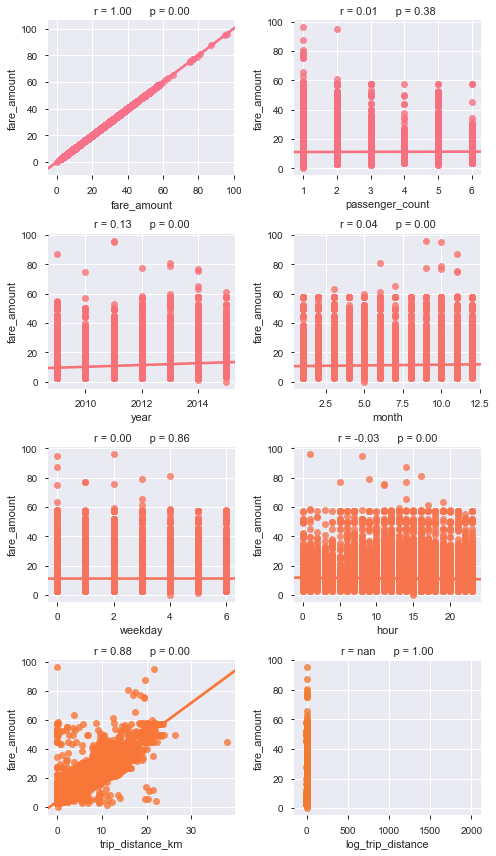

In [26]:
nr_rows = 4
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
#li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) ]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(dp_train[li_plot_num_feats[i]], dp_train[target], ax = axs[r][c])
            stp = stats.pearsonr(dp_train[li_plot_num_feats[i]], dp_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

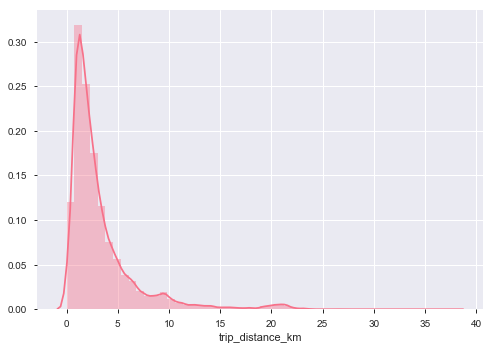

In [27]:
sns.distplot(dp_train.trip_distance_km)

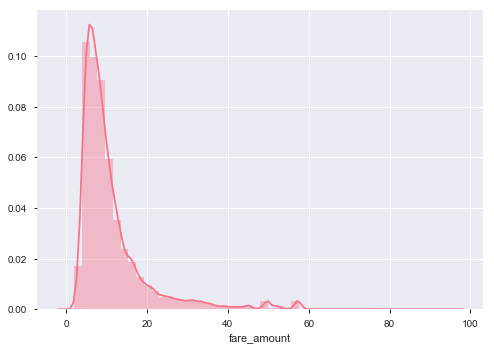

In [28]:
sns.distplot(dp_train.fare_amount)

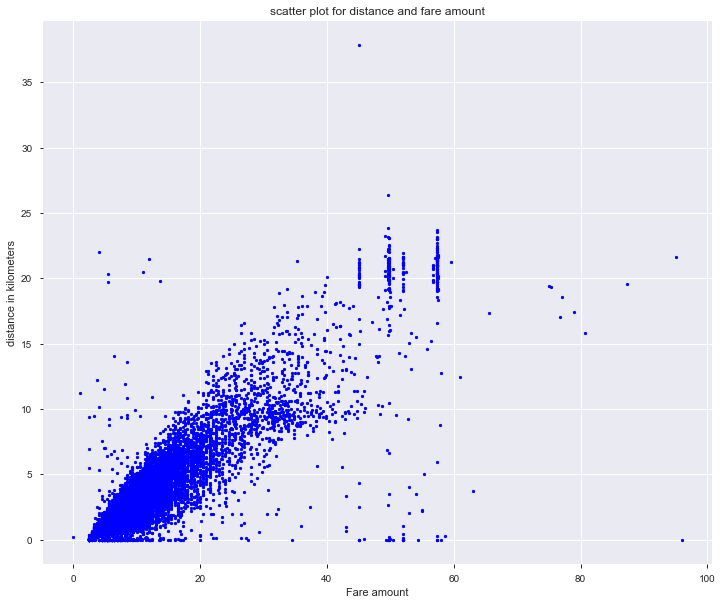

In [29]:
plt.figure(figsize = (12,10))

plt.scatter(dp_train["fare_amount"],
            dp_train["trip_distance_km"],s = 5,
            linewidths=1, c = "b")
plt.ylabel("distance in kilometers")
plt.xlabel("Fare amount")
plt.title("scatter plot for distance and fare amount")
#plt.savefig('Figure8.png')
plt.show()

In [30]:
dp_train.columns

Index(['fare_amount', 'passenger_count', 'year', 'month', 'weekday', 'hour',
       'trip_distance_km', 'log_trip_distance', 'log_fare_amount'],
      dtype='object')

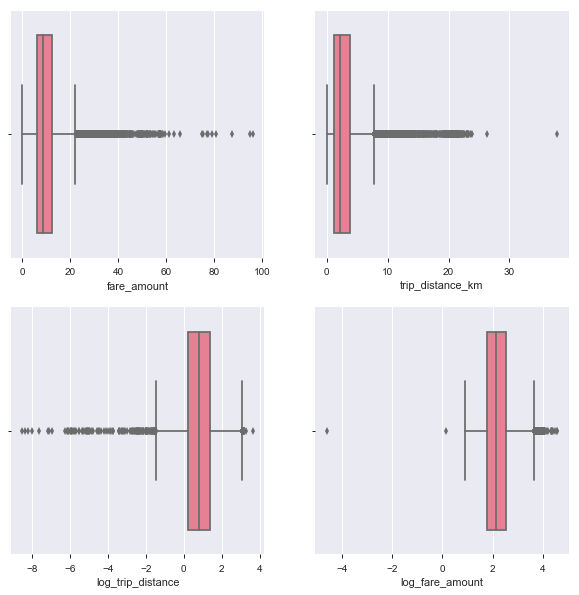

In [31]:
box = ['fare_amount',
       'trip_distance_km', 'log_trip_distance', 'log_fare_amount']
row = 2
col = 2
r = 0
c=0
i=0
fig,ax = plt.subplots(nrows=row,ncols=col)
fig.set_size_inches(10,10)

while r < row:
    c =0
    while c < col:
        sns.boxplot(x=box[i], y=None, hue=None, data=dp_train, order=None, hue_order=None, orient=None, color=None, palette=None,ax=ax[r,c])
        c=c+1
        i=i+1
    r=r+1

In [32]:
feature =  ["fare_amount","trip_distance_km","passenger_count"]
for i in feature:
    print(i)
    q75, q25 = np.percentile(dp_train.loc[:,i], [75 ,25])
    iqr = q75 - q25
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    
    dp_train = dp_train.drop(dp_train[dp_train.loc[:,i] < minimum].index)
    dp_train = dp_train.drop(dp_train[dp_train.loc[:,i] > maximum].index)   

fare_amount
trip_distance_km
passenger_count


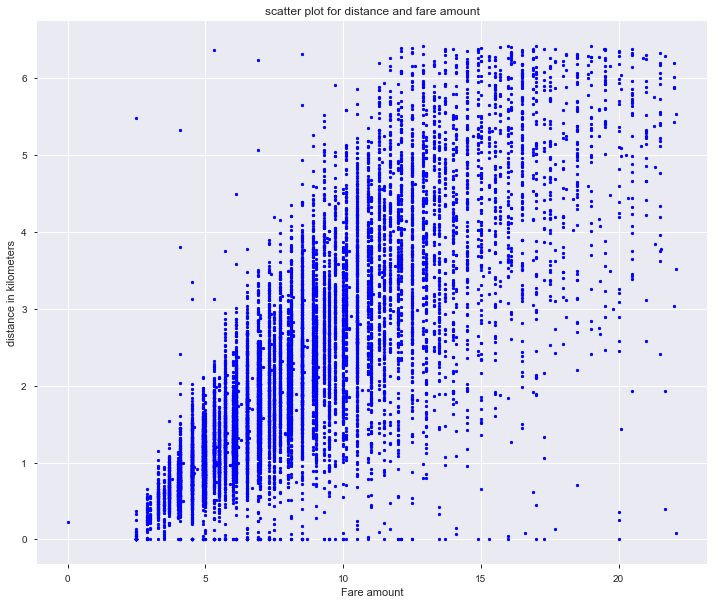

In [33]:
plt.figure(figsize = (12,10))

plt.scatter(dp_train["fare_amount"],
            dp_train["trip_distance_km"],s = 5,
            linewidths=1, c = "b")
plt.ylabel("distance in kilometers")
plt.xlabel("Fare amount")
plt.title("scatter plot for distance and fare amount")
#plt.savefig('Figure8.png')
plt.show()

# Feature Selection

In [34]:
dp_train.columns

Index(['fare_amount', 'passenger_count', 'year', 'month', 'weekday', 'hour',
       'trip_distance_km', 'log_trip_distance', 'log_fare_amount'],
      dtype='object')

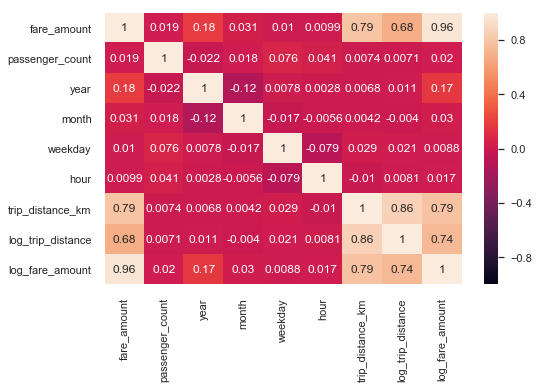

In [35]:
sns.set(rc={'figure.figsize':(8,5)})

dp_train['passenger_count'] = dp_train['passenger_count'].astype(int)
colname = ['fare_amount', 'passenger_count', 'year', 'month', 'weekday', 'hour',
       'trip_distance_km', 'log_trip_distance', 'log_fare_amount']
heat_map = dp_train[colname]
sns.heatmap(heat_map.corr(), vmin=-1.00, vmax=1.00, annot=True)

In [36]:
dm_train = dp_train.drop(['log_fare_amount','log_trip_distance'  ],axis=1)

dm_train.describe()
print(dm_train.shape)
print(dm_train.columns)

(12116, 7)
Index(['fare_amount', 'passenger_count', 'year', 'month', 'weekday', 'hour',
       'trip_distance_km'],
      dtype='object')


In [37]:
#********************************** Modeling *****************************************************************
from sklearn import metrics
#function to check performance  
def performance(actual, predict):
    print('MSE:', metrics.mean_squared_error(actual, predict)) 
    print('RMSE:', np.sqrt(metrics.mean_squared_error(actual, predict))) 
    print('MAPE:',np.mean(np.abs((actual-predict)/actual))*100)
    print('R-Sq:', metrics.r2_score(actual, predict))

In [38]:
#********************************** Sampling *****************************************************************
##Sampling: dividing  Test and train data  using sklearn 
from sklearn.model_selection import train_test_split,KFold, cross_val_score, cross_val_predict
import copy
#moving the amount to last variable
dm_train['amount']= copy.copy(dm_train['fare_amount'])
dm_train = dm_train.drop(['fare_amount'], axis=1)

#Random sample selection 
trains, tests = train_test_split(dm_train, test_size = 0.25, random_state = 100)
dm_train.shape, tests.shape , trains.shape


((12116, 7), (3029, 7), (9087, 7))

In [39]:
print(dm_train.columns)

Index(['passenger_count', 'year', 'month', 'weekday', 'hour',
       'trip_distance_km', 'amount'],
      dtype='object')


In [40]:
#1. ############################################ Decision Tree ############################################################
###Model 1
from sklearn.tree import DecisionTreeRegressor

dt1 = DecisionTreeRegressor(max_depth =3, random_state=123).fit(trains.iloc[:,0:6],trains.iloc[:,6])
prediction_dt1 = dt1.predict(tests.iloc[:,0:6])

#error matrix
performance(tests.iloc[:,6],prediction_dt1)
print('                           ')
print('Perdicted Vs Actual value: ')
prediction_dt1[1], tests.iloc[1,6]

MSE: 4.767422915686128
RMSE: 2.1834429041507195
MAPE: 19.924447250964846
R-Sq: 0.6534079978007419
                           
Perdicted Vs Actual value: 


(11.873381962864721, 9.5)

In [41]:
dt1.score(trains.iloc[:,0:6],trains.iloc[:,6])

0.63245344610671

In [42]:
#2. ############################################ Random Forest ############################################################
###Model 2


rf1 = RandomForestRegressor(n_estimators = 500, random_state = 126).fit(trains.iloc[:,0:6],trains.iloc[:,6])
prediction_rf1 = rf1.predict(tests.iloc[:,0:6])

#error matrix
performance(tests.iloc[:,6],prediction_rf1)
print('                           ')
print('Perdicted Vs Actual value: ')
prediction_rf1[1], tests.iloc[1,6]

MSE: 4.208860491442851
RMSE: 2.0515507528313432
MAPE: 18.829866551465532
R-Sq: 0.6940155277798368
                           
Perdicted Vs Actual value: 


(11.002, 9.5)

In [43]:
rf1.score(trains.iloc[:,0:6],trains.iloc[:,6])

0.9536329939037377

In [44]:
#3. ############################################ Linear Regression ############################
###Model 3

from sklearn.linear_model import LinearRegression
#1.Simple Linear Regression Model 3


ln1 = LinearRegression().fit(trains.iloc[:,0:6],trains.iloc[:,6])
prediction_slr1 = ln1.predict(tests.iloc[:,0:6])

#error matrix
performance(tests.iloc[:,6],prediction_slr1)
print('                           ')
print('Perdicted Vs Actual value: ')
prediction_slr1[1], tests.iloc[1,6]

MSE: 4.413336243050162
RMSE: 2.1007941934064274
MAPE: 19.013550502107673
R-Sq: 0.6791501253592553
                           
Perdicted Vs Actual value: 


(11.330765033478315, 9.5)

In [45]:
ln1.score(trains.iloc[:,0:6],trains.iloc[:,6])

0.6582518294316004

In [46]:
#4. ############################################ Ridge Regression ############################
###Model 4
from sklearn import linear_model
#Ridge model


ln2 = linear_model.Ridge(alpha=.5).fit(trains.iloc[:,0:6],trains.iloc[:,6])
prediction_slr2 = ln2.predict(tests.iloc[:,0:6])

#error matrix
performance(tests.iloc[:,6],prediction_slr2)
print('                           ')
print('Perdicted Vs Actual value: ')
prediction_slr2[1], tests.iloc[1,6]

MSE: 4.413344394318453
RMSE: 2.100796133449996
MAPE: 19.013740777987927
R-Sq: 0.6791495327614414
                           
Perdicted Vs Actual value: 


(11.330703330216807, 9.5)

In [47]:
ln2.score(trains.iloc[:,0:6],trains.iloc[:,6])

0.6582518289477994

Text(0, 0.5, 'Predicted values')

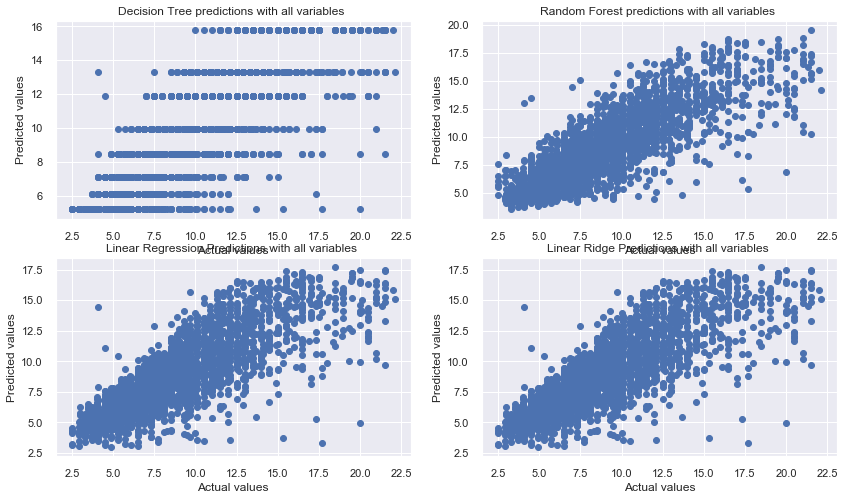

In [48]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.title('Decision Tree predictions with all variables ')
plt.scatter(tests.iloc[:,6] , prediction_dt1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.subplot(2,2,2)
plt.title('Random Forest predictions with all variables ')
plt.scatter(tests.iloc[:,6] , prediction_rf1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.subplot(2,2,3)
plt.title('Linear Regression Predictions with all variables ')
plt.scatter(tests.iloc[:,6] , prediction_slr1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.subplot(2,2,4)
plt.title('Linear Ridge Predictions with all variables ')
plt.scatter(tests.iloc[:,6] , prediction_slr2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')


In [49]:
#As per comparision i am choosing Random forest with all varisbles predictor for my given test dataset

# Implementation on Test dataset

In [50]:
Gtest = pd.read_csv("test.csv", parse_dates=['pickup_datetime'])

In [51]:
Gtest['pickup_datetime'] = pd.to_datetime(Gtest['pickup_datetime'], errors='coerce')
Gtest = Gtest.dropna(subset=['pickup_datetime'])

In [52]:
Gtest['year']=Gtest['pickup_datetime'].dt.year
Gtest['month']=Gtest['pickup_datetime'].dt.month
Gtest['weekday']=Gtest['pickup_datetime'].dt.weekday
Gtest['hour']=Gtest['pickup_datetime'].dt.hour

In [53]:
Gtest['abs_longi']=abs(Gtest['pickup_longitude']-Gtest['dropoff_longitude'])
Gtest['abs_lat']=abs(Gtest['pickup_latitude']-Gtest['dropoff_latitude'])

In [54]:
#Calculatig distance from log and lati with great circle formula
def great_circle_distance(lon1,lat1,lon2,lat2):
    R = 6371000 # Approximate mean radius of earth (in m)
    
    # Convert decimal degrees to ridians
    lon1,lat1,lon2,lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Distance of lons and lats in radians
    dis_lon = lon2 - lon1
    dis_lat = lat2 - lat1
    
    # Haversine implementation
    a = np.sin(dis_lat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dis_lon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    dis_m = R*c # Distance in meters
    dis_km = dis_m/1000 # Distance in km
    return dis_km
Gtest['distance'] = great_circle_distance(Gtest.pickup_longitude, Gtest.pickup_latitude, Gtest.dropoff_longitude, Gtest.dropoff_latitude)
Gtest.head(10)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,abs_longi,abs_lat,distance
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,0.008110,0.019970,2.323259
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,0.012024,0.019817,2.425353
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,0.002870,0.005121,0.618628
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,0.009288,0.016172,1.961033
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,0.022519,0.045348,5.387301
5,2012-12-01 21:12:12+00:00,-73.960983,40.765547,-73.979177,40.740053,1,2012,12,5,21,0.018194,0.025494,3.222549
6,2011-10-06 12:10:20+00:00,-73.949013,40.773204,-73.959622,40.770893,1,2011,10,3,12,0.010609,0.002311,0.929601
7,2011-10-06 12:10:20+00:00,-73.777282,40.646636,-73.985083,40.759368,1,2011,10,3,12,0.207801,0.112732,21.540102
8,2011-10-06 12:10:20+00:00,-74.014099,40.709638,-73.995106,40.741365,1,2011,10,3,12,0.018993,0.031727,3.873962
9,2014-02-18 15:22:20+00:00,-73.969582,40.765519,-73.980686,40.770725,1,2014,2,1,15,0.011104,0.005206,1.099794


In [55]:
Gtest = Gtest.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'abs_longi', 'abs_lat'], axis=1)

In [56]:
Gtest.head()

,passenger_count,year,month,weekday,hour,distance
0,1,2015,1,1,13,2.323259
1,1,2015,1,1,13,2.425353
2,1,2011,10,5,11,0.618628
3,1,2012,12,5,21,1.961033
4,1,2012,12,5,21,5.387301


In [57]:
dm_train.columns

Index(['passenger_count', 'year', 'month', 'weekday', 'hour',
       'trip_distance_km', 'amount'],
      dtype='object')

In [58]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 127).fit(dm_train.iloc[:,0:6],dm_train.iloc[:,6])
amount = rf.predict(Gtest)

Gtest ['amount'] = amount

In [59]:
Gtest

,passenger_count,year,month,weekday,hour,distance,amount
0,1,2015,1,1,13,2.323259,12.7660
1,1,2015,1,1,13,2.425353,13.0800
2,1,2011,10,5,11,0.618628,4.6150
3,1,2012,12,5,21,1.961033,8.4570
4,1,2012,12,5,21,5.387301,17.5100
5,1,2012,12,5,21,3.222549,10.9090
6,1,2011,10,3,12,0.929601,5.5130
7,1,2011,10,3,12,21.540102,14.3662
8,1,2011,10,3,12,3.873962,12.0320
9,1,2014,2,1,15,1.099794,6.0600
